# initial bias 
### load imbalanced data

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
ok_sql = '''
    select path, test_label from metadata
    where 
        test_label = 'OK'
        and component like '%Cap'
        and extension = 'png'
'''
ng_sql = '''
    select path, test_label from metadata
    where 
        test_label != 'OK-InvalidPNG' 
        and test_label is not NULL
        and test_label != 'OK'
        and component like '%Cap'
        and extension = 'png'
'''

In [3]:
ok_path_label_ds = tf.data.experimental.SqlDataset(
    'sqlite', '/p3/metadata.db',
    ok_sql, (tf.string, tf.string)
)
ng_path_label_ds = tf.data.experimental.SqlDataset(
    'sqlite', '/p3/metadata.db',
    ng_sql, (tf.string, tf.string)
)

In [4]:
pos = len(list(ok_path_label_ds))
pos

526289

In [5]:
neg = len(list(ng_path_label_ds))
neg

13270

In [6]:
total = pos + neg
total

539559

### make dataset trainable

In [7]:
class_name = ['OK', 'NG']
class_index = tf.constant([0, 1], dtype=tf.int64)
lookup = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(class_name, class_index), -1
)
def parse_func(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
    img = tf.image.resize_with_pad(img, 32, 32)
    label = tf.strings.split(input=label, sep='-')[0]
    label = lookup.lookup(label)
    label = tf.one_hot(label, len(class_name), dtype='int64')
    label = tf.cast(label, dtype=tf.float32)
    return img, label

In [8]:
ok_parsed_ds = ok_path_label_ds.map(parse_func, tf.data.experimental.AUTOTUNE).shuffle(20000).repeat()
ng_parsed_ds = ng_path_label_ds.map(parse_func, tf.data.experimental.AUTOTUNE).shuffle(20000).repeat()

In [9]:
mixed_train_ds = tf.data.experimental.sample_from_datasets([
    ok_parsed_ds, ng_parsed_ds
])
train_ds = mixed_train_ds.skip(50000).batch(1024).prefetch(2)
val_ds = mixed_train_ds.take(50000).batch(1024).prefetch(2)

In [9]:
steps_per_epoch = np.ceil((pos-50000)/1024)
print(steps_per_epoch)
validation_steps = np.ceil(50000/1024)
print(validation_steps)

466.0
49.0


### model

In [8]:
import matplotlib.pyplot as plt
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [10]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_auc', 
#     verbose=1,
#     patience=10,
#     mode='max')

In [11]:
import tensorflow.keras.layers as l

def BaseModel(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        print(output_bias)
    inputs = tf.keras.Input((32, 32, 3), name="image")
    x = l.Conv2D(64, 7, padding="same")(inputs)
    x = l.ReLU()(x)
    for filters in [128, 256, 512]:
        x = l.Conv2D(filters, 3, padding="same")(x)
        x = l.BatchNormalization()(x)
        x = l.ReLU()(x)
        x = l.MaxPool2D()(x)
    x = l.Conv2D(1024, 3, padding="same")(x)
    x = l.BatchNormalization()(x)
    x = l.ReLU()(x)
    x = l.GlobalAveragePooling2D()(x)
    x = l.Dense(2, bias_initializer=output_bias)(x)
    x = l.Activation("softmax", dtype="float32")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-3),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=metrics)
    return model

### no initial bias training

In [14]:
zero_bias_model = BaseModel()
zero_bias_history = zero_bias_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds, 
    steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
    verbose=2)

Train for 466.0 steps
Epoch 1/10
466/466 - 73s - loss: 0.0345 - tp: 472921.0000 - fp: 4263.0000 - tn: 472921.0000 - fn: 4263.0000 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9911 - auc: 0.9982 - val_loss: 0.0461 - val_tp: 48960.0000 - val_fp: 1040.0000 - val_tn: 48960.0000 - val_fn: 1040.0000 - val_accuracy: 0.9792 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9989
Epoch 2/10
466/466 - 50s - loss: 0.0081 - tp: 475924.0000 - fp: 1260.0000 - tn: 475924.0000 - fn: 1260.0000 - accuracy: 0.9974 - precision: 0.9974 - recall: 0.9974 - auc: 0.9998 - val_loss: 0.4804 - val_tp: 42067.0000 - val_fp: 7933.0000 - val_tn: 42067.0000 - val_fn: 7933.0000 - val_accuracy: 0.8413 - val_precision: 0.8413 - val_recall: 0.8413 - val_auc: 0.9196
Epoch 3/10
466/466 - 50s - loss: 0.0031 - tp: 476789.0000 - fp: 395.0000 - tn: 476789.0000 - fn: 395.0000 - accuracy: 0.9992 - precision: 0.9992 - recall: 0.9992 - auc: 0.9999 - val_loss: 0.0555 - val_tp: 49119.0000 - val_fp: 881.0000 - val_tn: 491

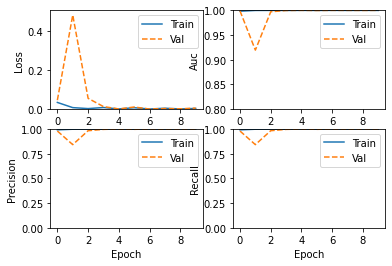

In [21]:
plot_metrics(zero_bias_history)

### class weight

In [12]:
mixed_sql = '''
    select path, test_label from metadata
    where 
        test_label != 'OK-InvalidPNG' 
        and test_label is not NULL
        and component like '%Cap'
        and extension = 'png'
'''

In [13]:
mixed_path_label_ds = tf.data.experimental.SqlDataset(
    'sqlite', '/p3/metadata.db',
    mixed_sql, (tf.string, tf.string)
)

In [15]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_1 = (1 / neg)*(total)/2.0 
weight_for_0 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 20.33


In [16]:
mixed_parsed_ds = mixed_path_label_ds.map(parse_func, tf.data.experimental.AUTOTUNE).shuffle(20000).repeat()
train_ds = mixed_parsed_ds.skip(50000).batch(1024).prefetch(2)
val_ds = mixed_parsed_ds.take(50000).batch(1024).prefetch(2)

In [17]:
class_weight_model = BaseModel()
class_weight_history = class_weight_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds, 
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight,
#     validation_steps=validation_steps,
    verbose=2)

Train for 466.0 steps, validate for 49 steps
Epoch 1/10
466/466 - 75s - loss: 0.0546 - tp: 468769.0000 - fp: 8415.0000 - tn: 468769.0000 - fn: 8415.0000 - accuracy: 0.9824 - precision: 0.9824 - recall: 0.9824 - auc: 0.9979 - val_loss: 0.0251 - val_tp: 48897.0000 - val_fp: 1103.0000 - val_tn: 48897.0000 - val_fn: 1103.0000 - val_accuracy: 0.9779 - val_precision: 0.9779 - val_recall: 0.9779 - val_auc: 0.9986
Epoch 2/10
466/466 - 51s - loss: 0.0380 - tp: 471958.0000 - fp: 5226.0000 - tn: 471958.0000 - fn: 5226.0000 - accuracy: 0.9890 - precision: 0.9890 - recall: 0.9890 - auc: 0.9988 - val_loss: 0.0053 - val_tp: 49847.0000 - val_fp: 153.0000 - val_tn: 49847.0000 - val_fn: 153.0000 - val_accuracy: 0.9969 - val_precision: 0.9969 - val_recall: 0.9969 - val_auc: 0.9999
Epoch 3/10
466/466 - 50s - loss: 0.0352 - tp: 472462.0000 - fp: 4722.0000 - tn: 472462.0000 - fn: 4722.0000 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - auc: 0.9985 - val_loss: 0.0016 - val_tp: 49953.0000 - val_fp:

### with bias

In [7]:
initial_bias = np.log([neg/pos])
initial_bias

-2.8402586644861954

In [15]:
with_bias_model = BaseModel(output_bias=initial_bias)
# with_bias_model.layers[-1].bias.assign(initial_bias)
with_bias_history =with_bias_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds, 
    steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
    verbose=2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        9472      
_________________________________________________________________
re_lu_5 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0   

Train for 523.0 steps, validate for 49.0 steps
Epoch 1/10
523/523 - 61s - loss: 5.9653e-08 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 267559.0000 - fn: 267993.0000 - accuracy: 0.4996 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8029 - val_loss: 5.9378e-08 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 25090.0000 - val_fn: 24910.0000 - val_accuracy: 0.5018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6276
Epoch 2/10
523/523 - 56s - loss: 5.9558e-08 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 267985.0000 - fn: 267567.0000 - accuracy: 0.5004 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5665 - val_loss: 5.9378e-08 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 25090.0000 - val_fn: 24910.0000 - val_accuracy: 0.5018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6290
Epoch 3/10
523/523 - 56s - loss: 5.9561e-08 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 267972.0000 - fn: 267580.0000 - accuracy: 0.5004 - precision: 0.0000e+00 - recall: 